In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov9-main

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/yolov9-main


In [2]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench_COCO_Panoptic_Plant/train")
count_images("/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench_COCO_Panoptic_Plant/val")
count_images("/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench/train/semantics")
count_images("/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench/val/semantics")

Total images: 1407
Total images: 772
Total images: 1407
Total images: 772


In [ ]:
import os
import numpy as np
from PIL import Image

def check_semantic_ids(semantic_dir):
    all_ids = set()
    for filename in os.listdir(semantic_dir):
        if filename.endswith(".png"):
            mask = np.array(Image.open(os.path.join(semantic_dir, filename)))
            unique_ids = np.unique(mask)
            all_ids.update(unique_ids.tolist())
    return sorted(all_ids)

semantic_dir = "datasets/PhenoBench/train/semantics"
unique_ids = check_semantic_ids(semantic_dir)
print("Unique semantic IDs found:", unique_ids)

Unique semantic IDs found: [0, 1, 2, 3, 4]


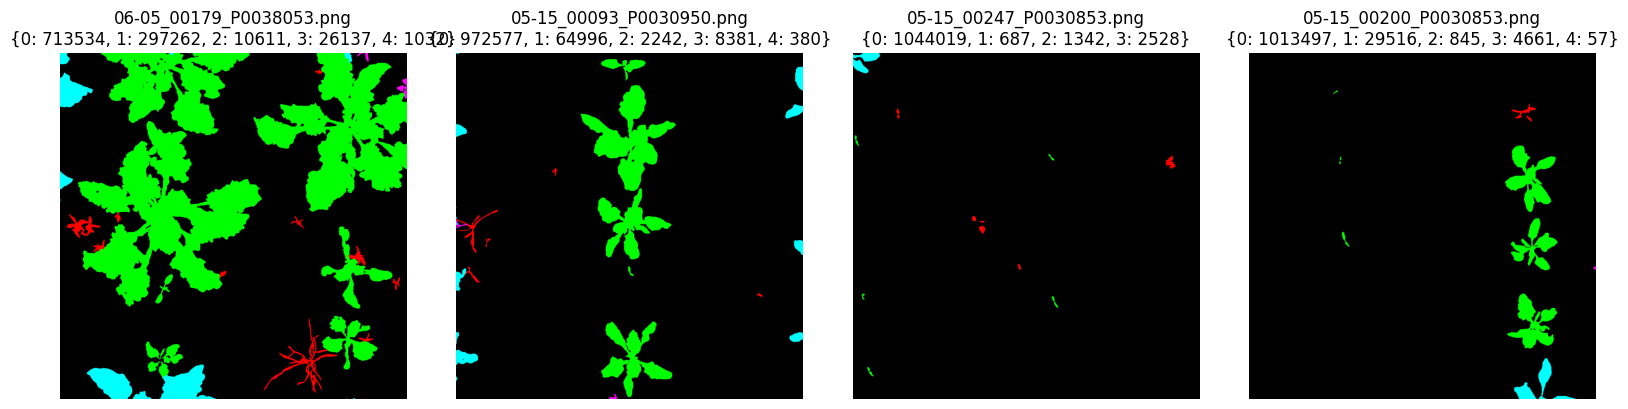

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define class ID to RGB color mapping
CATEGORY_COLORS = {
    0: [0, 0, 0],         # background
    1: [0, 255, 0],       # crop (green)
    2: [255, 0, 0],       # weed (red)
    3: [0, 255, 255],     # partial-crop (cyan)
    4: [255, 0, 255],     # partial-weed (purple)
}

def decode_mask(mask):
    """Convert class ID mask to RGB color mask"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CATEGORY_COLORS.items():
        color_mask[mask == class_id] = color
    return color_mask

def count_classes(mask):
    """Count pixel occurrences for each class"""
    unique, counts = np.unique(mask, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))

def visualize_random_semantics(mask_dir, num_samples=4):
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    selected = random.sample(mask_files, num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(16, 4))
    for i, filename in enumerate(selected):
        path = os.path.join(mask_dir, filename)
        mask = np.array(Image.open(path))
        color_mask = decode_mask(mask)
        class_counts = count_classes(mask)

        axes[i].imshow(color_mask)
        axes[i].set_title(f"{filename}\n{class_counts}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_random_semantics("datasets/PhenoBench/train/semantics")

In [ ]:
# Clone Segmenter
!git clone https://github.com/rstrudel/segmenter.git
%cd segmenter

# Install dependencies
!pip install -r requirements.txt

# Install Segmenter as editable package
!pip install -e .

In [ ]:
!pip install numpy==1.24.4

In [ ]:
!pip install torchmetrics

In [ ]:
!mkdir -p checkpoints/seg_tiny_mask
!wget https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/segmenter/checkpoints/ade20k/seg_tiny_mask/checkpoint.pth \
     -O checkpoints/seg_tiny_mask/checkpoint.pth

--2025-07-19 21:39:51--  https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/segmenter/checkpoints/ade20k/seg_tiny_mask/checkpoint.pth
Resolving storage.openvinotoolkit.org (storage.openvinotoolkit.org)... 3.169.231.33, 3.169.231.104, 3.169.231.109, ...
Connecting to storage.openvinotoolkit.org (storage.openvinotoolkit.org)|3.169.231.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27695600 (26M) [application/octet-stream]
Saving to: ‘checkpoints/seg_tiny_mask/checkpoint.pth’

checkpoints/seg_tin 100%[===================>]  26.41M  14.3MB/s    in 1.8s    

2025-07-19 21:39:53 (14.3 MB/s) - ‘checkpoints/seg_tiny_mask/checkpoint.pth’ saved [27695600/27695600]



In [2]:
%cd segmenter

/content/gdrive/MyDrive/yolov9-main/segmenter


In [4]:
%ls segm/model/

blocks.py  decoder.py  factory.py  __pycache__/  segmenter.py  utils.py  vit.py


In [5]:
# List functions in vit.py
import segm.model.vit as vit_module
print(dir(vit_module))

['Block', 'DropPath', 'PatchEmbedding', 'VisionTransformer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_load_weights', 'init_weights', 'nn', 'resize_pos_embed', 'torch', 'trunc_normal_']


In [5]:
import ast

path = '/content/gdrive/MyDrive/yolov9-main/segmenter/segm/model/decoder.py'
with open(path, 'r') as f:
    tree = ast.parse(f.read(), filename=path)

for node in tree.body:
    if isinstance(node, ast.ClassDef):
        print(f'Class: {node.name}')
    elif isinstance(node, ast.FunctionDef):
        print(f'Function: {node.name}')

Class: DecoderLinear
Class: MaskTransformer


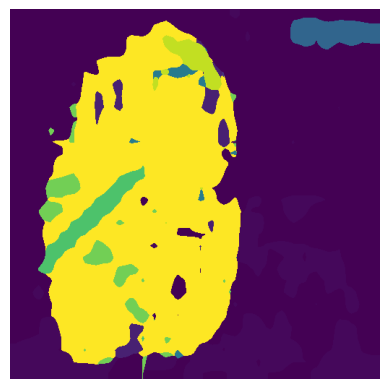

In [44]:
import torch
from PIL import Image
import torchvision.transforms as T
from segm.model.segmenter import Segmenter
from segm.model.vit import VisionTransformer, init_weights
from segm.model.decoder import DecoderLinear, MaskTransformer
import matplotlib.pyplot as plt
import inspect

#print(inspect.getsource(MaskTransformer.__init__))

# Paths
ckpt_path = '/content/gdrive/MyDrive/yolov9-main/checkpoints/seg_tiny_mask/checkpoint.pth'
img_path = 'Laparoscopic-Myomectomy-with-Baseball-Suturing-50-_jpg.rf.661aa9d5f3afd233168aabae5ec72736.jpg'

# Load checkpoint
ckpt = torch.load(ckpt_path, map_location='cpu')
#print(ckpt.keys())

# Image preprocessing
img = Image.open(img_path).convert('RGB')
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3),
])
x = transform(img).unsqueeze(0).cuda()

# Create encoder
encoder = VisionTransformer(
    image_size=(512, 512),
    patch_size=16,
    n_layers=12,
    d_model=192,
    d_ff=768,
    n_heads=3,
    n_cls=1000,  # Match checkpoint
)
init_weights(encoder)

# Create decoder
decoder = MaskTransformer(
    150,      # n_cls (mask tokens)
    16,       # patch_size
    192,      # d_encoder
    12,       # n_layers (guess)
    3,        # n_heads
    192,      # d_model
    768,      # d_ff
    0.1,      # drop_path_rate
    0.0,      # dropout
)
init_weights(decoder)

# Create segmenter
model = Segmenter(encoder=encoder, decoder=decoder, n_cls=5)

# Load checkpoint weights partially (only matching keys and shapes)
state_dict = ckpt['model']

model_state_dict = model.state_dict()
filtered_state_dict = {}

for k, v in state_dict.items():
    if k in model_state_dict:
        if v.shape == model_state_dict[k].shape:
            filtered_state_dict[k] = v
        else:
            print(f"Skipping loading parameter '{k}' due to shape mismatch {v.shape} vs {model_state_dict[k].shape}")
    else:
        print(f"Skipping loading parameter '{k}' not found in model")

model.load_state_dict(filtered_state_dict, strict=False)

model.cuda()
model.eval()

# Inference
with torch.no_grad():
    output = model(x)[0]
    pred_mask = output.argmax(0).cpu().numpy()

# Visualize
plt.imshow(pred_mask)
plt.axis('off')
plt.show()

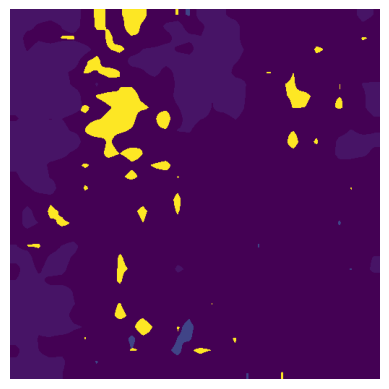

In [87]:
import torch
from PIL import Image
import torchvision.transforms as T
from segm.model.segmenter import Segmenter
from segm.model.vit import VisionTransformer, init_weights
from segm.model.decoder import MaskTransformer
import matplotlib.pyplot as plt
import numpy as np

# Dataset info
n_classes = 5
CATEGORY_COLORS = {
    0: [0, 0, 0],         # background
    1: [0, 255, 0],       # crop
    2: [255, 0, 0],       # weed
    3: [0, 255, 255],     # partial-crop
    4: [255, 0, 255],     # partial-weed
}

# Paths
ckpt_path = '/content/gdrive/MyDrive/yolov9-main/checkpoints/seg_tiny_mask/checkpoint.pth'
img_path = '/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench_COCO_Panoptic_Plant/train/05-26_00150_P0034117.png'

# Load checkpoint
ckpt = torch.load(ckpt_path, map_location='cpu')

# Image preprocessing
img = Image.open(img_path).convert('RGB')
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3),
])
x = transform(img).unsqueeze(0).cuda()

# Create encoder (keep n_cls=1000 to match checkpoint)
encoder = VisionTransformer(
    image_size=(512, 512),
    patch_size=16,
    n_layers=12,
    d_model=192,
    d_ff=768,
    n_heads=3,
    n_cls=1000,
)
init_weights(encoder)

# Create decoder (example: 5 classes * 30 tokens = 150)
decoder = MaskTransformer(
    n_cls=150,
    patch_size=16,
    d_encoder=192,
    n_layers=12,
    n_heads=3,
    d_model=192,
    d_ff=768,
    drop_path_rate=0.1,
    dropout=0.0,
)
init_weights(decoder)

# Create segmenter with your actual class count
model = Segmenter(encoder=encoder, decoder=decoder, n_cls=n_classes)

# Partial checkpoint loading (skip weights with shape mismatch)
state_dict = ckpt['model']
model_state_dict = model.state_dict()
filtered_state_dict = {
    k: v for k, v in state_dict.items()
    if k in model_state_dict and v.shape == model_state_dict[k].shape
}
model.load_state_dict(filtered_state_dict, strict=False)

model.cuda()
model.eval()

# Inference
with torch.no_grad():
    output = model(x)[0]
    pred_mask = output.argmax(0).cpu().numpy()

plt.imshow(pred_mask)
plt.axis('off')
plt.show()

In [46]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
from segm.model.segmenter import Segmenter
from segm.model.vit import VisionTransformer, init_weights
from segm.model.decoder import MaskTransformer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from tqdm import tqdm

In [29]:
# Dataset class
class PhenoBenchSemSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_names = sorted(os.listdir(img_dir))
        self.mask_names = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)  # ← this must return a tensor
        else:
            image = T.ToTensor()(image)   # ← fallback

        mask = torch.from_numpy(np.array(mask)).long()

        # ✅ Add debug here
        assert isinstance(image, torch.Tensor), f"image is {type(image)}"
        assert isinstance(mask, torch.Tensor), f"mask is {type(mask)}"

        return image, mask

In [30]:
# Paths
train_img_dir = "/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench_COCO_Panoptic_Plant/train"
val_img_dir = "/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench_COCO_Panoptic_Plant/val"
train_mask_dir = "/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench/train/semantics"
val_mask_dir = "/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench/val/semantics"

# Transforms
train_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

val_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

In [31]:
# Dataset & DataLoader
train_dataset = PhenoBenchSemSegDataset(train_img_dir, train_mask_dir, transform=train_transform)
val_dataset = PhenoBenchSemSegDataset(val_img_dir, val_mask_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

In [32]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create encoder & decoder with same architecture as pretrained weights
encoder = VisionTransformer(
    image_size=(512, 512),
    patch_size=16,
    n_layers=12,
    d_model=192,
    d_ff=768,
    n_heads=3,
    n_cls=1000,  # as per pretrained checkpoint
)
init_weights(encoder)

decoder = MaskTransformer(
    150,  # mask tokens from checkpoint
    16,
    192,
    12,
    3,
    192,
    768,
    0.1,
    0.0,
)
init_weights(decoder)

# Create segmenter model with correct number of classes
model = Segmenter(encoder=encoder, decoder=decoder, n_cls=5)  # your dataset has 5 classes
model = model.to(device)

In [ ]:
# Load checkpoint weights with filtering for shape match
ckpt_path = '/content/gdrive/MyDrive/yolov9-main/checkpoints/seg_tiny_mask/checkpoint.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
state_dict = ckpt['model']

model_state_dict = model.state_dict()
filtered_state_dict = {}

for k, v in state_dict.items():
    if k in model_state_dict and v.shape == model_state_dict[k].shape:
        filtered_state_dict[k] = v
    else:
        print(f"Skipping parameter '{k}' due to shape mismatch or missing")

model.load_state_dict(filtered_state_dict, strict=False)

In [34]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [35]:
def compute_miou(pred, target, num_classes):
    # Ensure both are PyTorch tensors
    if isinstance(pred, np.ndarray):
        pred = torch.from_numpy(pred)
    if isinstance(target, np.ndarray):
        target = torch.from_numpy(target)

    pred = pred.view(-1)
    target = target.view(-1)
    ious = []

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = torch.logical_and(pred_inds, target_inds).sum().item()
        union = torch.logical_or(pred_inds, target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    ious = [iou for iou in ious if not np.isnan(iou)]
    return np.mean(ious) if ious else 0.0

In [40]:
def validate(model, dataloader, device, num_classes):
    model.eval()
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for image, target in dataloader:
            image = image.to(device)

            # ensure target is tensor
            if isinstance(target, (list, tuple)):
                target = torch.stack([t if isinstance(t, torch.Tensor) else torch.tensor(t) for t in target])
            target = target.to(device)

            output = model(image)  # <-- FIXED HERE, no ['out']
            pred = torch.argmax(output, dim=1)

            for i in range(image.size(0)):
                pred_i = pred[i]
                target_i = target[i]

                if pred_i.shape != target_i.shape:
                    pred_i = torch.nn.functional.interpolate(
                        pred_i[None, None].float(),
                        size=target_i.shape,
                        mode='nearest'
                    )[0, 0].long()

                iou = compute_miou(pred_i, target_i, num_classes)
                total_iou += iou
                total_samples += 1

    return total_iou / total_samples if total_samples > 0 else 0.0

In [43]:
torch.cuda.empty_cache()

In [42]:
best_miou = 0
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        # --- Fix output shape handling ---
        outputs_raw = model(imgs)
        outputs = outputs_raw['out'] if isinstance(outputs_raw, dict) else outputs_raw  # [B, C, H, W]

        # --- Fix mask shape: resize to output size ---
        masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()

        # Optional debug print
        # print("Output shape:", outputs.shape)
        # print("Mask shape:", masks.shape)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    # Validation
    val_miou = validate(model, val_loader, device, num_classes=5)
    print(f"Epoch {epoch+1} validation mIoU: {val_miou:.4f}")

    # Save best model checkpoint
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), "/content/gdrive/MyDrive/yolov9-main/checkpoints/segmenter_best.pth")
        print(f"✅ Saved best model at epoch {epoch+1} with mIoU: {val_miou:.4f}")

Epoch 1/10: 100%|██████████| 176/176 [02:07<00:00,  1.38it/s]

Epoch 1 training loss: 0.1283


Epoch 1 validation mIoU: 0.4284
✅ Saved best model at epoch 1 with mIoU: 0.4284


Epoch 2/10: 100%|██████████| 176/176 [02:07<00:00,  1.38it/s]

Epoch 2 training loss: 0.1179


Epoch 2 validation mIoU: 0.4416
✅ Saved best model at epoch 2 with mIoU: 0.4416


Epoch 3/10: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]

Epoch 3 training loss: 0.1117


Epoch 3 validation mIoU: 0.4651
✅ Saved best model at epoch 3 with mIoU: 0.4651


Epoch 4/10: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]

Epoch 4 training loss: 0.1066


Epoch 4 validation mIoU: 0.4644


Epoch 5/10: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]

Epoch 5 training loss: 0.1025


Epoch 5 validation mIoU: 0.4681
✅ Saved best model at epoch 5 with mIoU: 0.4681


Epoch 6/10: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]

Epoch 6 training loss: 0.0999


Epoch 6 validation mIoU: 0.4535


Epoch 7/10: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]

Epoch 7 training loss: 0.0969


Epoch 7 validation mIoU: 0.4844
✅ Saved best model at epoch 7 with mIoU: 0.4844


Epoch 8/10: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]

Epoch 8 training loss: 0.0939


Epoch 8 validation mIoU: 0.4920
✅ Saved best model at epoch 8 with mIoU: 0.4920


Epoch 9/10: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]

Epoch 9 training loss: 0.0923


Epoch 9 validation mIoU: 0.4992
✅ Saved best model at epoch 9 with mIoU: 0.4992


Epoch 10/10: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]

Epoch 10 training loss: 0.0909


Epoch 10 validation mIoU: 0.4992


In [54]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/yolov9-main/checkpoints/segmenter_best.pth"))

print("✅ Best model loaded.")

✅ Best model loaded.


In [56]:
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

NUM_CLASSES = 5
CLASS_NAMES = ["background", "crop", "weed", "partial-crop", "partial-weed"]

# Initialize metrics
iou_metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, average=None).to(device)
precision_metric = MulticlassPrecision(num_classes=NUM_CLASSES, average=None).to(device)
recall_metric = MulticlassRecall(num_classes=NUM_CLASSES, average=None).to(device)
f1_metric = MulticlassF1Score(num_classes=NUM_CLASSES, average=None).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
model.to(device)

with torch.no_grad():
    for imgs, masks in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs_raw = model(imgs)
        outputs = outputs_raw['out'] if isinstance(outputs_raw, dict) else outputs_raw  # [B, C, H, W]

        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        # Resize masks if needed (to output size)
        if masks.shape != preds.shape:
            masks = F.interpolate(masks.unsqueeze(1).float(), size=preds.shape[1:], mode='nearest').squeeze(1).long()

        iou_metric.update(preds, masks)
        precision_metric.update(preds, masks)
        recall_metric.update(preds, masks)
        f1_metric.update(preds, masks)

per_class_iou = iou_metric.compute().cpu().numpy()
per_class_precision = precision_metric.compute().cpu().numpy()
per_class_recall = recall_metric.compute().cpu().numpy()
per_class_f1 = f1_metric.compute().cpu().numpy()

print()
print("📊 Per-Class Evaluation Metrics:")
print(f"{'Class':<15} {'IoU':>6} {'Prec':>6} {'Rec':>6} {'F1':>6}")
print("-" * 40)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:<15} "
          f"{per_class_iou[i]:6.3f} "
          f"{per_class_precision[i]:6.3f} "
          f"{per_class_recall[i]:6.3f} "
          f"{per_class_f1[i]:6.3f}")

Evaluating: 100%|██████████| 97/97 [00:20<00:00,  4.84it/s]


📊 Per-Class Evaluation Metrics:
Class              IoU   Prec    Rec     F1
----------------------------------------
background       0.973  0.988  0.985  0.986
crop             0.739  0.839  0.861  0.850
weed             0.330  0.612  0.418  0.497
partial-crop     0.557  0.661  0.779  0.715
partial-weed     0.026  0.253  0.029  0.052


In [68]:
import os
import random
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Constants (same normalization as training)
IMG_MEAN = np.array([0.5, 0.5, 0.5])  # Align with your normalization mean
IMG_STD = np.array([0.5, 0.5, 0.5])   # Align with your normalization std

CATEGORY_COLORS = {
    0: [0, 0, 0],
    1: [0, 255, 0],
    2: [255, 0, 0],
    3: [0, 255, 255],
    4: [255, 0, 255],
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms: just ToTensor + Normalize, no resize
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN.tolist(), std=IMG_STD.tolist()),
])

# Paths to your validation images and masks folder
val_img_dir = "/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench_COCO_Panoptic_Plant/val"
val_mask_dir = "/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench/val/semantics"

# List images (make sure images and masks have matching filenames except extension)
val_images = sorted([f for f in os.listdir(val_img_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))])

# Visualize val set predictions
def visualize_val_predictions(model, num_images=6, alpha=0.4):
    model.eval()
    indices = random.sample(range(len(val_images)), num_images)

    fig, axes = plt.subplots(num_images, 4, figsize=(16, 4 * num_images))
    if num_images == 1:
        axes = np.expand_dims(axes, 0)

    for i, idx in enumerate(indices):
        img_name = val_images[idx]
        img_path = os.path.join(val_img_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"  # assuming mask is png with same basename
        mask_path = os.path.join(val_mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        gt_mask = Image.open(mask_path)

        input_tensor = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(input_tensor)
            if isinstance(logits, dict):
                logits = logits.get('out', list(logits.values())[0])
            pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

        image_np = (input_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy() * np.array(IMG_STD) + np.array(IMG_MEAN)) * 255
        image_np = np.clip(image_np, 0, 255).astype(np.uint8)

        gt_np = np.array(gt_mask)

        # Decode masks to RGB colors
        gt_rgb = np.zeros((*gt_np.shape, 3), dtype=np.uint8)
        pred_rgb = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
        for cls, col in CATEGORY_COLORS.items():
            gt_rgb[gt_np == cls] = col
            pred_rgb[pred_mask == cls] = col

        overlay = ((1 - alpha) * image_np + alpha * pred_rgb).astype(np.uint8)

        axes[i][0].imshow(image_np)
        axes[i][1].imshow(gt_rgb)
        axes[i][2].imshow(pred_rgb)
        axes[i][3].imshow(overlay)

        for c in range(4):
            axes[i][c].axis('off')

    for col, title in enumerate(["Original", "Ground Truth", "Prediction", "Overlay"]):
        axes[0][col].set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

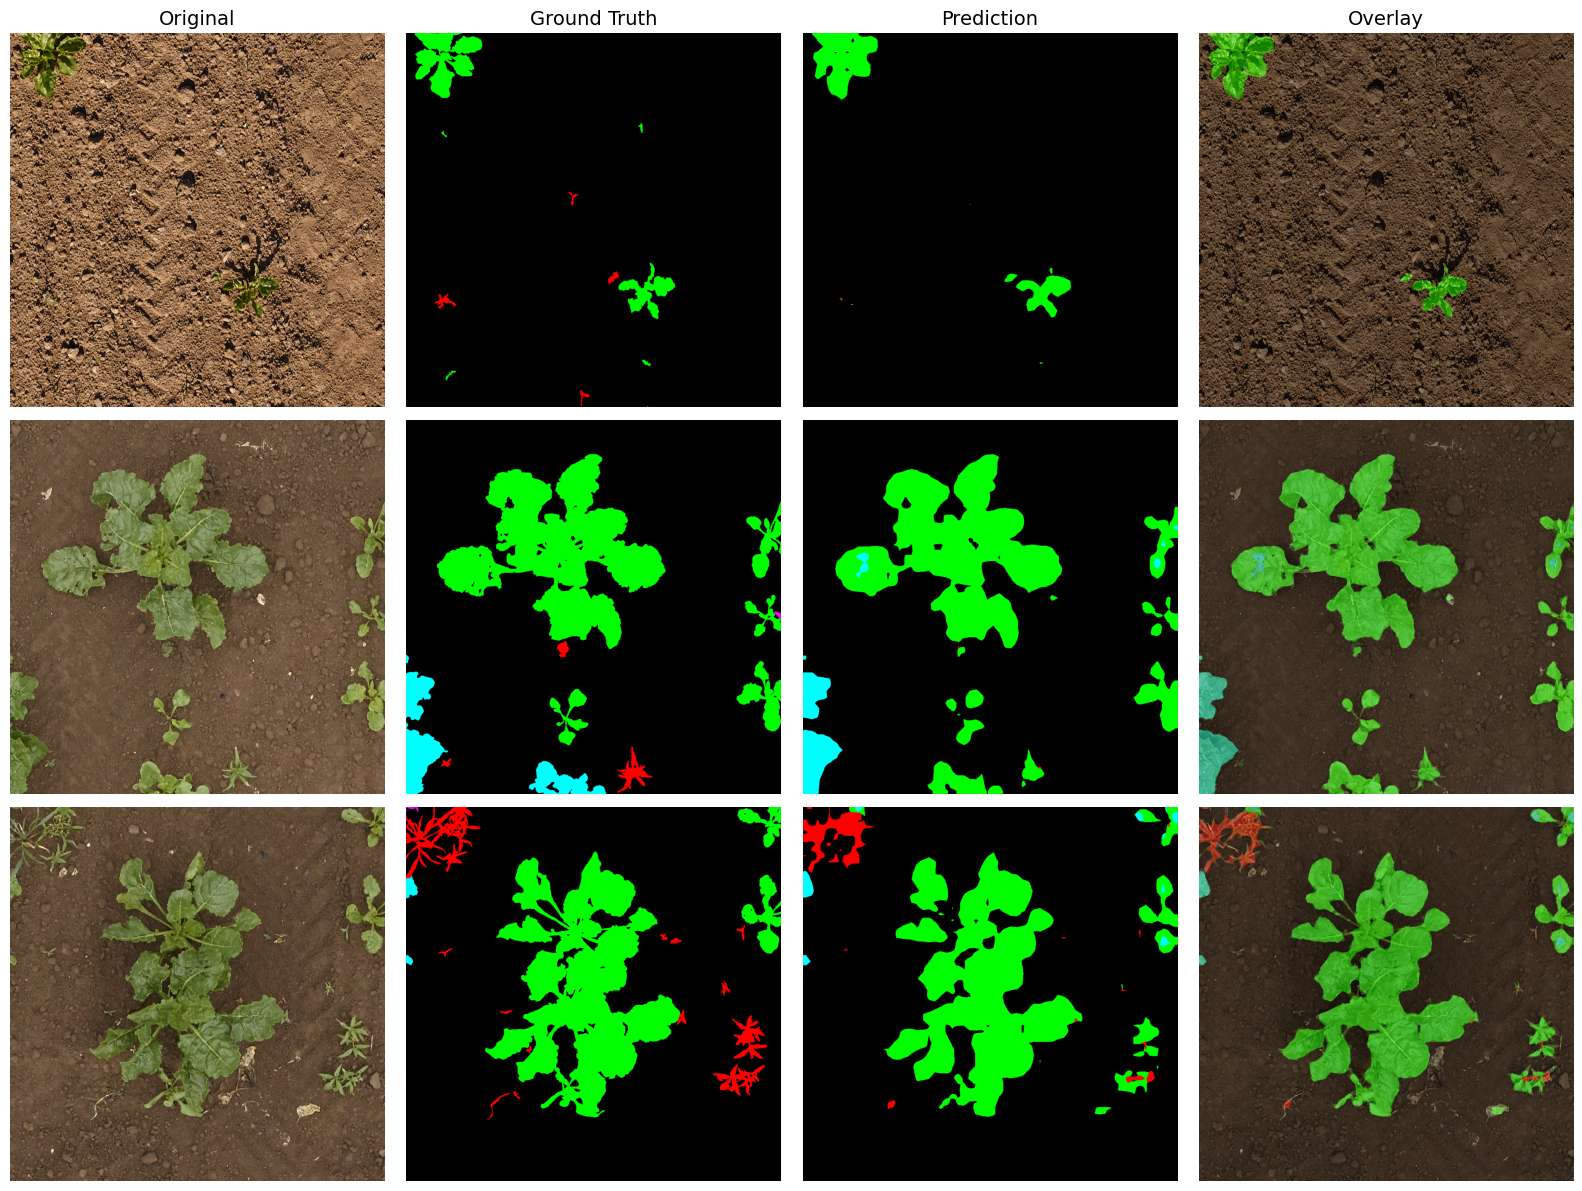

In [90]:
# Example: visualize 3 random samples with alpha=0.4
visualize_val_predictions(model, num_images=3, alpha=0.4)

In [62]:
import os
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# === Constants
IMG_MEAN = np.array([0.5, 0.5, 0.5])  # Align with your normalization mean
IMG_STD = np.array([0.5, 0.5, 0.5])   # Align with your normalization std

CATEGORY_COLORS = {
    0: [0, 0, 0],         # background
    1: [0, 255, 0],       # crop
    2: [255, 0, 0],       # weed
    3: [0, 255, 255],     # partial-crop
    4: [255, 0, 255],     # partial-weed
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Decode predicted mask
def decode_mask(mask):
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CATEGORY_COLORS.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

# === Preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN.tolist(), std=IMG_STD.tolist()),
])

# === Visualize model predictions on test set
def visualize_test_predictions(model, test_img_dir, num_images=6, alpha=0.4):
    model.eval()

    all_images = sorted([
        f for f in os.listdir(test_img_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
    ])

    if num_images > len(all_images):
        num_images = len(all_images)

    indices = random.sample(range(len(all_images)), num_images)

    ncols = 6  # 2 images per row × 3 cols (orig, pred, overlay)
    nrows = (num_images + 1) // 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4 * nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for i, idx in enumerate(indices):
        filename = all_images[idx]
        path = os.path.join(test_img_dir, filename)

        image = Image.open(path).convert("RGB")
        input_tensor = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(input_tensor)
            pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

        image_np = np.array(image)
        pred_rgb = decode_mask(pred_mask)
        overlay = ((1 - alpha) * image_np + alpha * pred_rgb).astype(np.uint8)

        row = i // 2
        col_base = (i % 2) * 3

        axes[row][col_base].imshow(image_np)
        axes[row][col_base].axis("off")
        if row == 0:
            axes[row][col_base].set_title("Original", fontsize=12)

        axes[row][col_base + 1].imshow(pred_rgb)
        axes[row][col_base + 1].axis("off")
        if row == 0:
            axes[row][col_base + 1].set_title("Prediction", fontsize=12)

        axes[row][col_base + 2].imshow(overlay)
        axes[row][col_base + 2].axis("off")
        if row == 0:
            axes[row][col_base + 2].set_title("Overlay", fontsize=12)

    plt.tight_layout()
    plt.show()

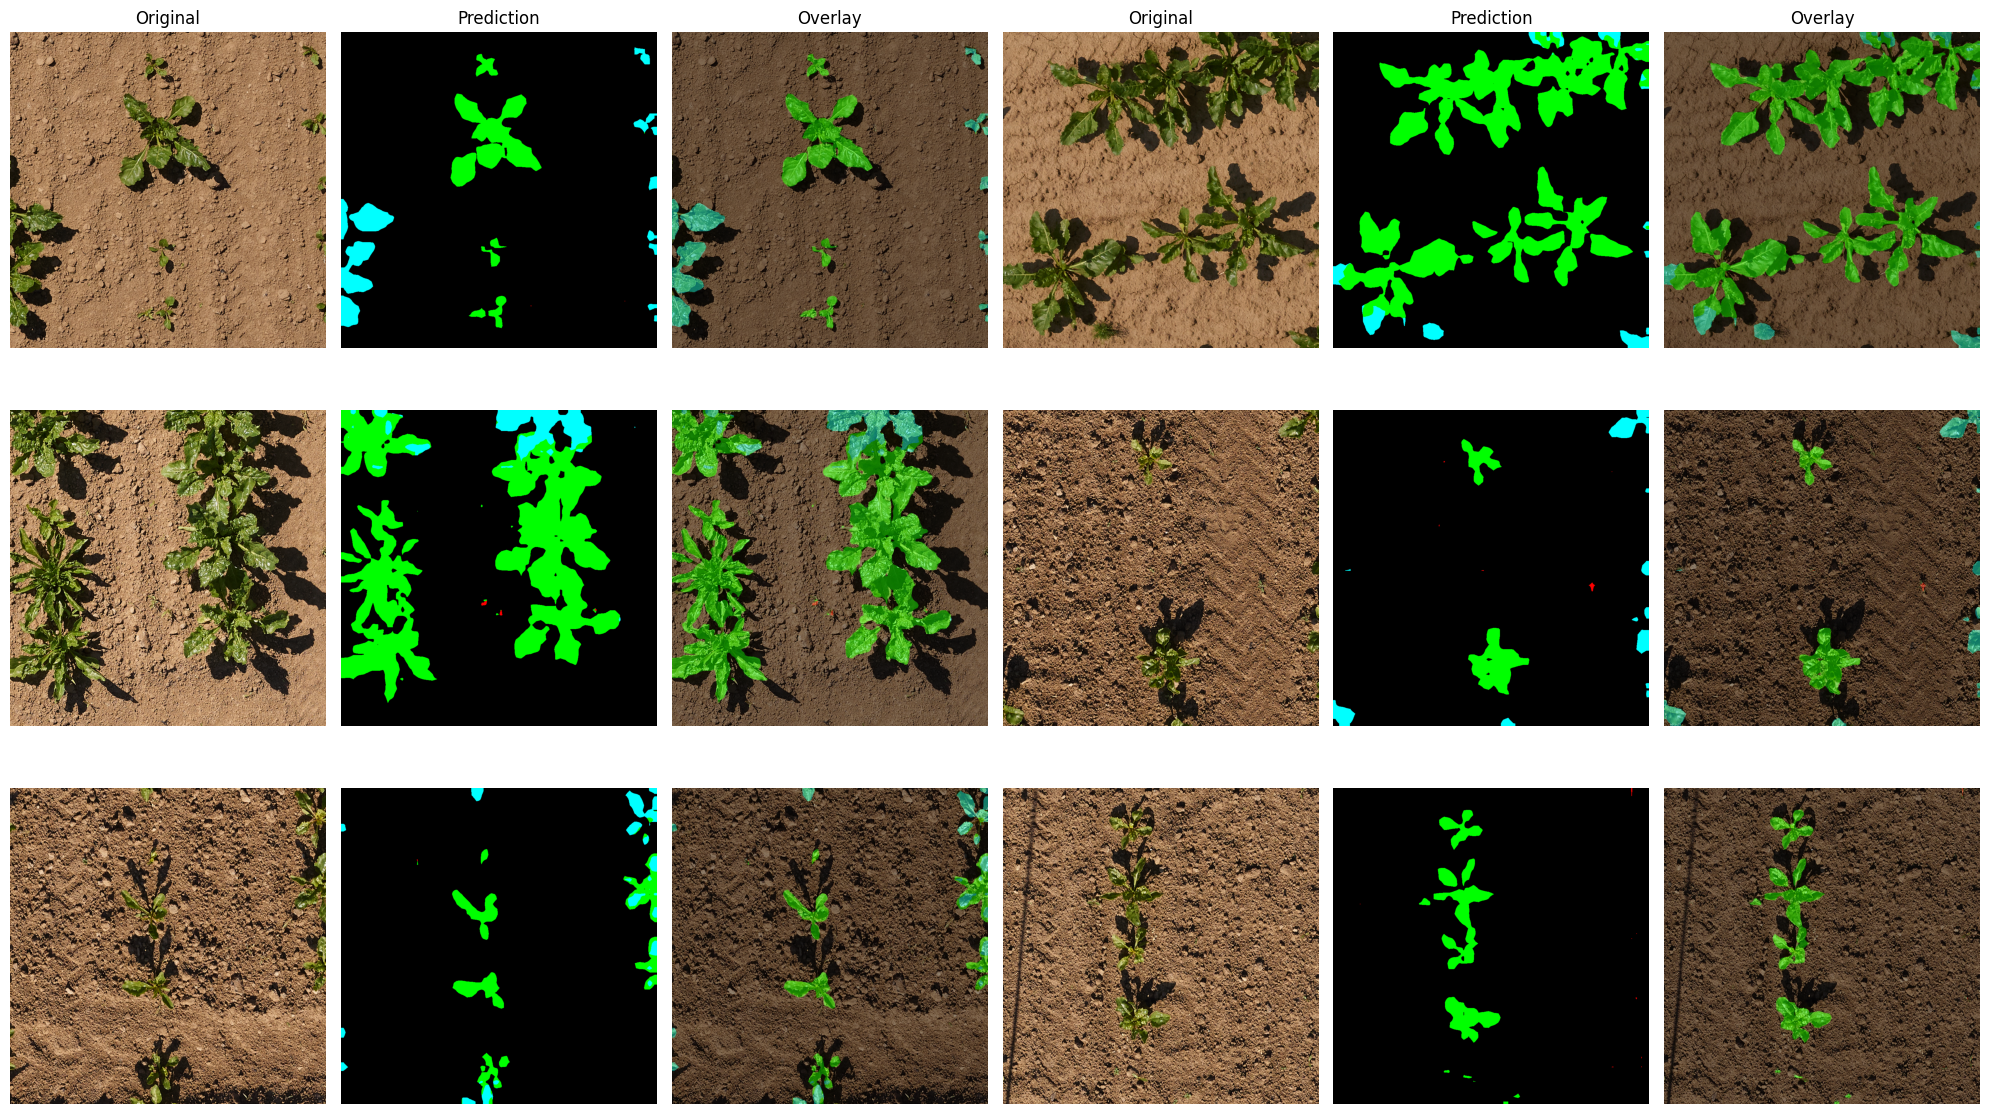

In [63]:
# Usage example:
visualize_test_predictions(model, "/content/gdrive/MyDrive/yolov9-main/datasets/PhenoBench/test/images", num_images=6, alpha=0.4)